## Importing the relevant libraries

In [1]:
import torch, time
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [2]:
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device())
    print("Device Name:", torch.cuda.get_device_name())

Device: 0
Device Name: Tesla T4


## Loading the train and test images

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [4]:
test_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [5]:
train_set = datasets.ImageFolder(root="/kaggle/input/lung-cancer-images12000-imagesmostly/dataset/training_set",transform=train_transforms)
test_set = datasets.ImageFolder(root="/kaggle/input/lung-cancer-images12000-imagesmostly/dataset/test_set",transform=test_transforms)

In [6]:
train_set

Dataset ImageFolder
    Number of datapoints: 12000
    Root location: /kaggle/input/lung-cancer-images12000-imagesmostly/dataset/training_set
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.3)
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
test_set

Dataset ImageFolder
    Number of datapoints: 2997
    Root location: /kaggle/input/lung-cancer-images12000-imagesmostly/dataset/test_set
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Loading images using DataLoader to segregate them into batches

In [8]:
train_loader = DataLoader(dataset=train_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device='cuda')
test_loader = DataLoader(dataset=test_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device='cuda')

In [9]:
for images, labels in train_loader:
    break

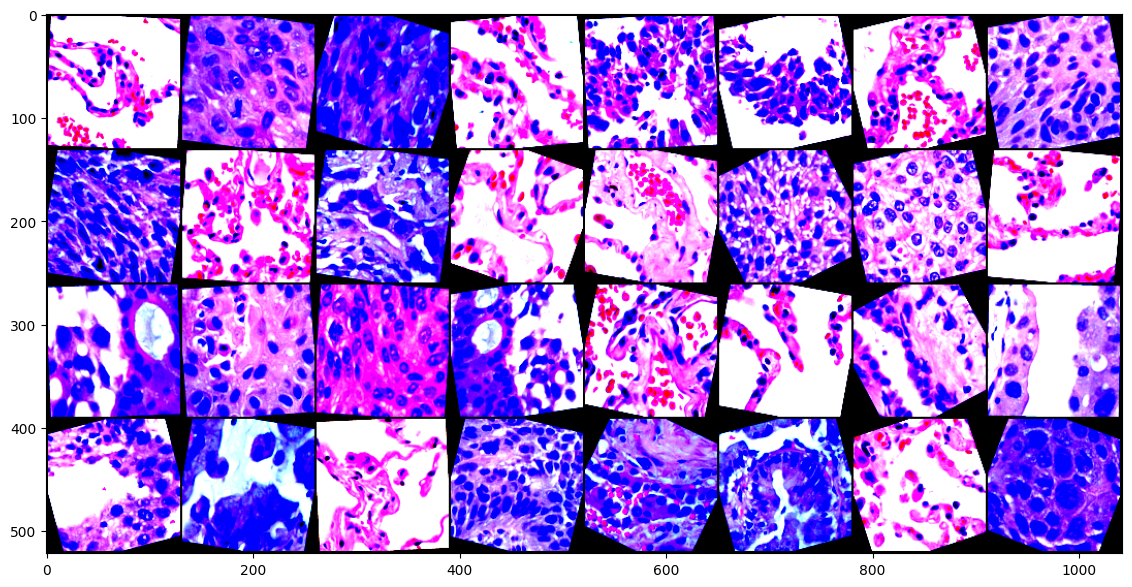

In [10]:
img_grid = make_grid(images,nrow=8)
inv_normalize = transforms.Normalize(mean=[-0.485/0.229,0.456/0.224,0.406/0.225],std=[1/0.229,1/0.224,1/0.225])

normalized_images = inv_normalize(images)

plt.figure(figsize=(14,7))
plt.imshow(np.transpose(img_grid.numpy(),(1,2,0)));

In [11]:
images.shape

torch.Size([32, 3, 128, 128])

## Defining the model architecture

In [12]:
class ConvolutionalNeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1) # 63,63,32
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1) # 31,31,64
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1) # 15,15,128
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1) # 6,6,256
        self.fc1 = nn.Linear(in_features=6*6*256,out_features=128)
        self.fc2 = nn.Linear(in_features=128,out_features=64)
        self.fc3 = nn.Linear(in_features=64,out_features=32)
        self.fc4 = nn.Linear(in_features=32,out_features=3)
    
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,6*6*256)
        X = F.relu(self.fc1(X))
        X = F.dropout(X,p=0.5)
        X = F.relu(self.fc2(X))
        X = F.dropout(X,p=0.4)
        X = F.relu(self.fc3(X))
        X = F.dropout(X,p=0.3)
        X = self.fc4(X)
        return F.log_softmax(X,dim=1)

In [13]:
torch.manual_seed(42)
model = ConvolutionalNeuralNetwork().cuda()
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
)

In [14]:
next(model.parameters()).is_cuda

True

In [15]:
total_params = 0

for param in model.parameters():
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of CNN model:", total_params)

864
32
18432
64
73728
128
294912
256
1179648
128
8192
64
2048
32
96
3
Total parameters of CNN model: 1578627


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(params=model.parameters(),lr=0.001)

In [17]:
start_time = time.time()

epochs = 25

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
    
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_accuracies.append(train_correct.item()/len(train_set))
    
    with torch.no_grad():
        
        for batch_no, (X_test,y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = model(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()  
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_accuracies.append(test_correct.item()/len(test_set))

print(f"Total time elapsed in CNN model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 0.6622862219810486
Epoch 1 Batch 100 -> Loss: 0.5709528923034668
Epoch 1 Batch 150 -> Loss: 0.5718791484832764
Epoch 1 Batch 200 -> Loss: 0.4683695435523987
Epoch 1 Batch 250 -> Loss: 0.39775171875953674
Epoch 1 Batch 300 -> Loss: 0.3641605079174042
Epoch 1 Batch 350 -> Loss: 0.3349994719028473
Epoch 2 Batch 50 -> Loss: 0.2519611716270447
Epoch 2 Batch 100 -> Loss: 0.4302782118320465
Epoch 2 Batch 150 -> Loss: 0.5332849621772766
Epoch 2 Batch 200 -> Loss: 0.41070666909217834
Epoch 2 Batch 250 -> Loss: 0.4016183316707611
Epoch 2 Batch 300 -> Loss: 0.21907535195350647
Epoch 2 Batch 350 -> Loss: 0.37064096331596375
Epoch 3 Batch 50 -> Loss: 0.13426360487937927
Epoch 3 Batch 100 -> Loss: 0.30960434675216675
Epoch 3 Batch 150 -> Loss: 0.2889675199985504
Epoch 3 Batch 200 -> Loss: 0.17968542873859406
Epoch 3 Batch 250 -> Loss: 0.29166513681411743
Epoch 3 Batch 300 -> Loss: 0.059788718819618225
Epoch 3 Batch 350 -> Loss: 0.4984878897666931
Epoch 4 Batch 50 -> Loss: 0

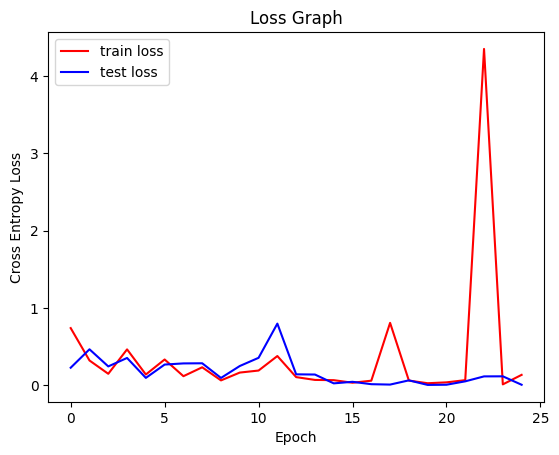

In [18]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

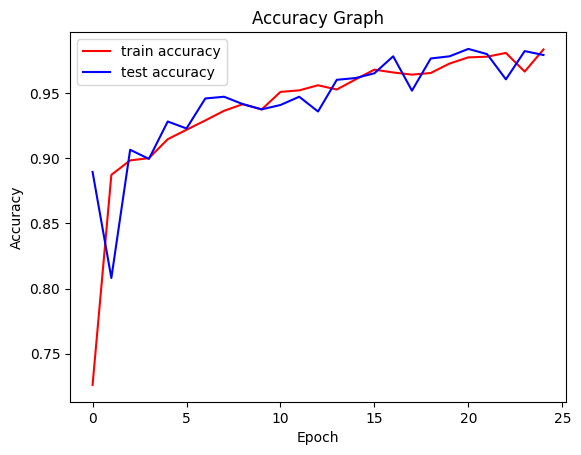

In [19]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [20]:
torch.save(model,'lung_cancer_baseline_detector.pt')

## Fine-tuning several pre-trained image classification models

### AlexNet

In [21]:
alexnet = models.alexnet(pretrained = True)
alexnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 183MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
total_params = 0

for param in alexnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of AlexNet model:", total_params)

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000
Total parameters of AlexNet model: 61100840


In [23]:
alexnet.classifier = nn.Sequential(
    nn.Linear(9216,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=alexnet.classifier.parameters(),lr=0.001)

In [25]:
alexnet = alexnet.cuda()

In [26]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
    
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = alexnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_accuracies.append(train_correct.item()/len(train_set))
    
    with torch.no_grad():
        
        for batch_no, (X_test,y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = alexnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()  
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_accuracies.append(test_correct.item()/len(test_set))

print(f"Total time elapsed in AlexNet model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 0.15862664580345154
Epoch 1 Batch 100 -> Loss: 0.496652752161026
Epoch 1 Batch 150 -> Loss: 0.39307066798210144
Epoch 1 Batch 200 -> Loss: 0.18234749138355255
Epoch 1 Batch 250 -> Loss: 0.2164304256439209
Epoch 1 Batch 300 -> Loss: 0.19018082320690155
Epoch 1 Batch 350 -> Loss: 0.17491352558135986
Epoch 2 Batch 50 -> Loss: 0.048723191022872925
Epoch 2 Batch 100 -> Loss: 0.14508330821990967
Epoch 2 Batch 150 -> Loss: 0.21337132155895233
Epoch 2 Batch 200 -> Loss: 0.15264612436294556
Epoch 2 Batch 250 -> Loss: 0.11512374132871628
Epoch 2 Batch 300 -> Loss: 0.18165606260299683
Epoch 2 Batch 350 -> Loss: 0.19504626095294952
Epoch 3 Batch 50 -> Loss: 0.0800442099571228
Epoch 3 Batch 100 -> Loss: 0.46758735179901123
Epoch 3 Batch 150 -> Loss: 0.19199290871620178
Epoch 3 Batch 200 -> Loss: 0.23123808205127716
Epoch 3 Batch 250 -> Loss: 0.3824176490306854
Epoch 3 Batch 300 -> Loss: 0.32467636466026306
Epoch 3 Batch 350 -> Loss: 0.1544700264930725
Epoch 4 Batch 50 -> L

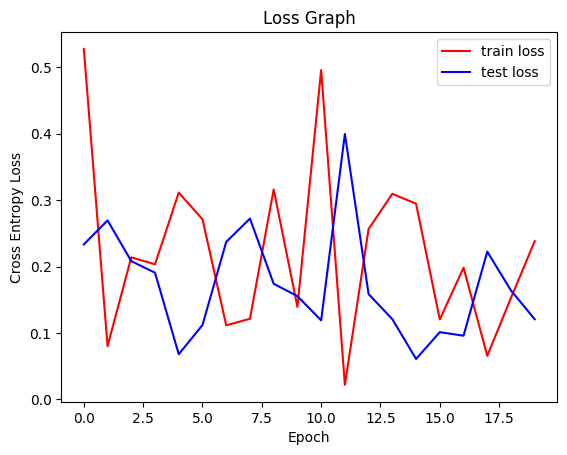

In [27]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

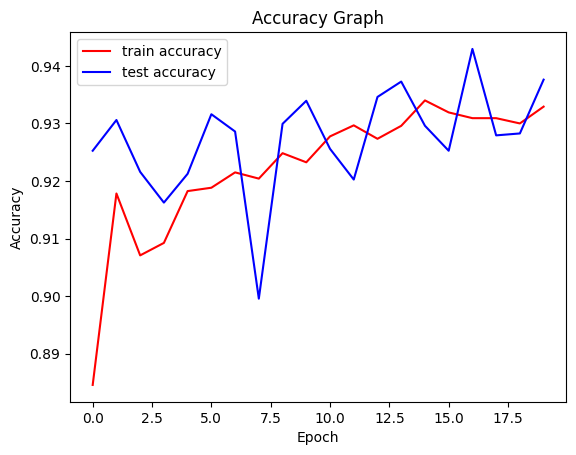

In [28]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [29]:
torch.save(alexnet,'lung_cancer_alexnet_detector.pt')

### VGG16

In [30]:
vgg16 = models.vgg16(pretrained=True)
vgg16

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 199MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
total_params = 0

for param in vgg16.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of VGG16 model:", total_params)

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000
Total parameters of VGG16 model: 138357544


In [32]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vgg16.classifier.parameters(),lr=0.001)

In [34]:
vgg16 = vgg16.cuda()

In [35]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
    
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = vgg16(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_accuracies.append(train_correct.item()/len(train_set))
    
    with torch.no_grad():
        
        for batch_no, (X_test,y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = vgg16(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()  
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_accuracies.append(test_correct.item()/len(test_set))

print(f"Total time elapsed in VGG16 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 0.6281607151031494
Epoch 1 Batch 100 -> Loss: 0.2827153503894806
Epoch 1 Batch 150 -> Loss: 0.2534695565700531
Epoch 1 Batch 200 -> Loss: 0.3280923664569855
Epoch 1 Batch 250 -> Loss: 0.18906933069229126
Epoch 1 Batch 300 -> Loss: 0.23242545127868652
Epoch 1 Batch 350 -> Loss: 0.25119268894195557
Epoch 2 Batch 50 -> Loss: 0.22987976670265198
Epoch 2 Batch 100 -> Loss: 0.5886099338531494
Epoch 2 Batch 150 -> Loss: 0.23815496265888214
Epoch 2 Batch 200 -> Loss: 0.25705641508102417
Epoch 2 Batch 250 -> Loss: 0.6325846910476685
Epoch 2 Batch 300 -> Loss: 0.31315872073173523
Epoch 2 Batch 350 -> Loss: 0.11793398857116699
Epoch 3 Batch 50 -> Loss: 0.16546976566314697
Epoch 3 Batch 100 -> Loss: 0.20610865950584412
Epoch 3 Batch 150 -> Loss: 0.2237236499786377
Epoch 3 Batch 200 -> Loss: 0.820546567440033
Epoch 3 Batch 250 -> Loss: 0.1387784332036972
Epoch 3 Batch 300 -> Loss: 0.1568296253681183
Epoch 3 Batch 350 -> Loss: 0.13998183608055115
Epoch 4 Batch 50 -> Loss: 0

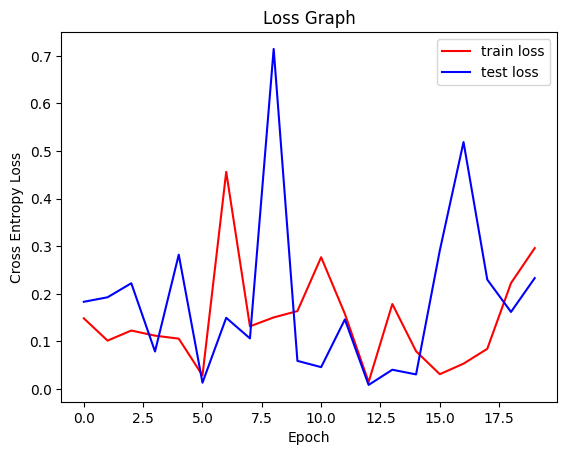

In [36]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

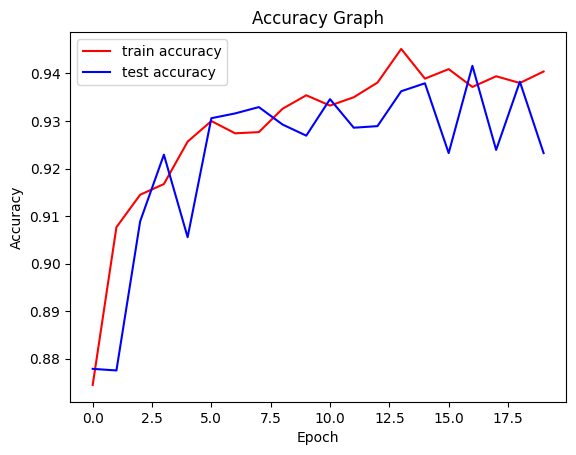

In [37]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [38]:
torch.save(vgg16,'lung_cancer_vgg16_detector.pt')

### ResNet101

In [39]:
resnet101 = models.resnet101(pretrained=True)
resnet101

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 180MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
total_params = 0

for param in resnet101.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of ResNet101 model:", total_params)

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024


In [41]:
resnet101.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
resnet101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet101.fc.parameters(),lr=0.001)

In [43]:
resnet101 = resnet101.cuda()

In [44]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
    
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = resnet101(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_accuracies.append(train_correct.item()/len(train_set))
    
    with torch.no_grad():
        
        for batch_no, (X_test,y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = resnet101(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()  
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_accuracies.append(test_correct.item()/len(test_set))

print(f"Total time elapsed in ResNet101 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 0.5895507335662842
Epoch 1 Batch 100 -> Loss: 0.19129782915115356
Epoch 1 Batch 150 -> Loss: 0.12801405787467957
Epoch 1 Batch 200 -> Loss: 0.25140729546546936
Epoch 1 Batch 250 -> Loss: 0.18449051678180695
Epoch 1 Batch 300 -> Loss: 0.280374675989151
Epoch 1 Batch 350 -> Loss: 0.12379617989063263
Epoch 2 Batch 50 -> Loss: 0.6186476945877075
Epoch 2 Batch 100 -> Loss: 0.17338508367538452
Epoch 2 Batch 150 -> Loss: 0.14563702046871185
Epoch 2 Batch 200 -> Loss: 0.2070368379354477
Epoch 2 Batch 250 -> Loss: 0.10260384529829025
Epoch 2 Batch 300 -> Loss: 0.06836795806884766
Epoch 2 Batch 350 -> Loss: 0.28387510776519775
Epoch 3 Batch 50 -> Loss: 0.21835942566394806
Epoch 3 Batch 100 -> Loss: 0.08406825363636017
Epoch 3 Batch 150 -> Loss: 0.24901556968688965
Epoch 3 Batch 200 -> Loss: 0.3226274847984314
Epoch 3 Batch 250 -> Loss: 0.1951485425233841
Epoch 3 Batch 300 -> Loss: 0.2272222638130188
Epoch 3 Batch 350 -> Loss: 0.16171319782733917
Epoch 4 Batch 50 -> Loss

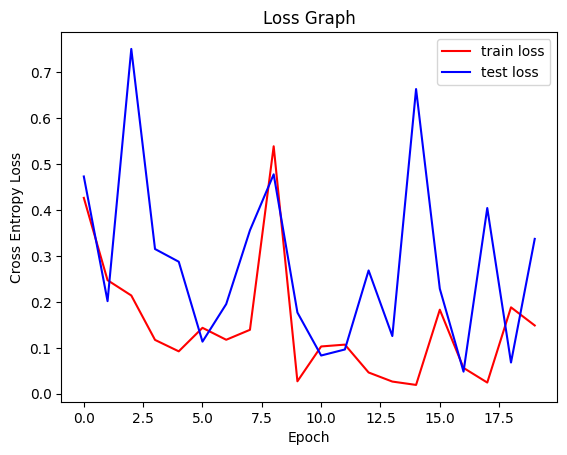

In [45]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

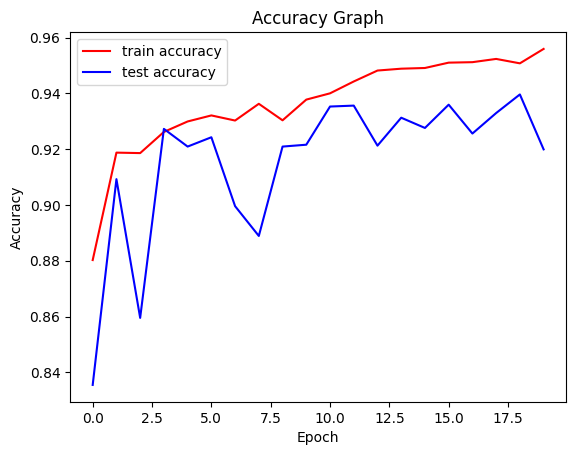

In [46]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [47]:
torch.save(resnet101,'lung_cancer_resnet101_detector.pt')

### MobileNet v3 large

In [48]:
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_large

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 160MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [49]:
total_params = 0

for param in mobilenet_v3_large.parameters(): 
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of Mobile Net v3 large:", total_params)

432
16
16
144
16
16
256
16
16
1024
64
64
576
64
64
1536
24
24
1728
72
72
648
72
72
1728
24
24
1728
72
72
1800
72
72
1728
24
1728
72
2880
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
9600
240
240
2160
240
240
19200
80
80
16000
200
200
1800
200
200
16000
80
80
14720
184
184
1656
184
184
14720
80
80
14720
184
184
1656
184
184
14720
80
80
38400
480
480
4320
480
480
57600
120
57600
480
53760
112
112
75264
672
672
6048
672
672
112896
168
112896
672
75264
112
112
75264
672
672
16800
672
672
112896
168
112896
672
107520
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
1228800
1280
1280000
1000
Total parameters of Mobile Net v3 large: 5483032


In [50]:
mobilenet_v3_large.classifier = nn.Sequential(
    nn.Linear(960,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
mobilenet_v3_large

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(params=mobilenet_v3_large.classifier.parameters(),lr=0.001)

In [52]:
mobilenet_v3_large = mobilenet_v3_large.cuda()

In [53]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
    
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = mobilenet_v3_large(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_accuracies.append(train_correct.item()/len(train_set))
    
    with torch.no_grad():
        
        for batch_no, (X_test,y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = mobilenet_v3_large(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()  
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_accuracies.append(test_correct.item()/len(test_set))

print(f"Total time elapsed in MobileNet v3 large model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 0.13864293694496155
Epoch 1 Batch 100 -> Loss: 0.324325293302536
Epoch 1 Batch 150 -> Loss: 0.30719447135925293
Epoch 1 Batch 200 -> Loss: 0.22321362793445587
Epoch 1 Batch 250 -> Loss: 0.6341937184333801
Epoch 1 Batch 300 -> Loss: 0.11724940687417984
Epoch 1 Batch 350 -> Loss: 0.28883790969848633
Epoch 2 Batch 50 -> Loss: 0.3523836135864258
Epoch 2 Batch 100 -> Loss: 0.2105177640914917
Epoch 2 Batch 150 -> Loss: 0.25046229362487793
Epoch 2 Batch 200 -> Loss: 0.26792141795158386
Epoch 2 Batch 250 -> Loss: 0.22779616713523865
Epoch 2 Batch 300 -> Loss: 0.17263637483119965
Epoch 2 Batch 350 -> Loss: 0.43171995878219604
Epoch 3 Batch 50 -> Loss: 0.04887780174612999
Epoch 3 Batch 100 -> Loss: 0.1697324961423874
Epoch 3 Batch 150 -> Loss: 0.238383486866951
Epoch 3 Batch 200 -> Loss: 0.32451438903808594
Epoch 3 Batch 250 -> Loss: 0.3490622639656067
Epoch 3 Batch 300 -> Loss: 0.04232192784547806
Epoch 3 Batch 350 -> Loss: 0.057560134679079056
Epoch 4 Batch 50 -> Loss

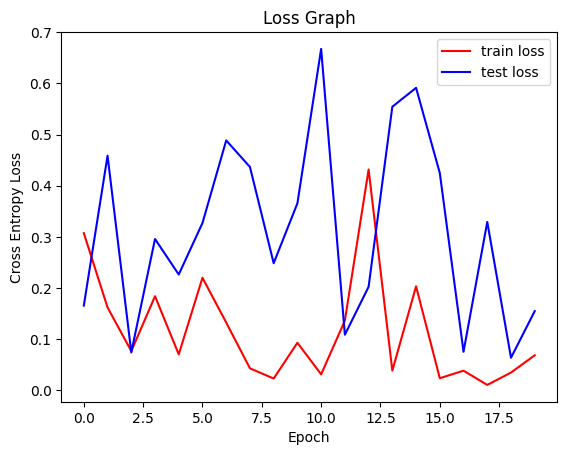

In [54]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

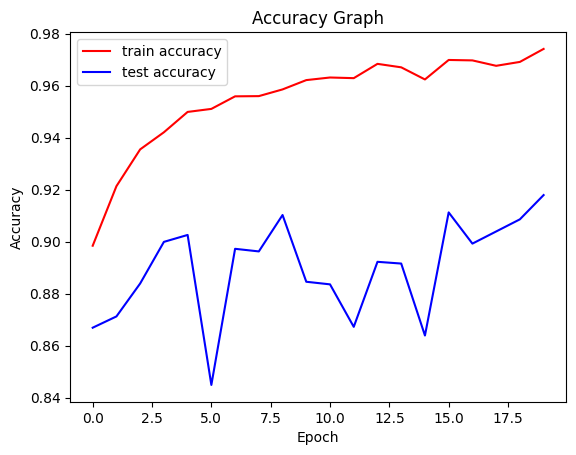

In [55]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [56]:
torch.save(mobilenet_v3_large,'lung_cancer_mobilenet_detector.pt')

### DenseNet121

In [57]:
densenet121 = models.densenet121(pretrained=True)
densenet121

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 158MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [58]:
total_params = 0

for param in densenet121.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()
    
print("Total parameters of DenseNet121 model:", total_params)

9408
64
64
64
64
8192
128
128
36864
96
96
12288
128
128
36864
128
128
16384
128
128
36864
160
160
20480
128
128
36864
192
192
24576
128
128
36864
224
224
28672
128
128
36864
256
256
32768
128
128
16384
128
128
36864
160
160
20480
128
128
36864
192
192
24576
128
128
36864
224
224
28672
128
128
36864
256
256
32768
128
128
36864
288
288
36864
128
128
36864
320
320
40960
128
128
36864
352
352
45056
128
128
36864
384
384
49152
128
128
36864
416
416
53248
128
128
36864
448
448
57344
128
128
36864
480
480
61440
128
128
36864
512
512
131072
256
256
32768
128
128
36864
288
288
36864
128
128
36864
320
320
40960
128
128
36864
352
352
45056
128
128
36864
384
384
49152
128
128
36864
416
416
53248
128
128
36864
448
448
57344
128
128
36864
480
480
61440
128
128
36864
512
512
65536
128
128
36864
544
544
69632
128
128
36864
576
576
73728
128
128
36864
608
608
77824
128
128
36864
640
640
81920
128
128
36864
672
672
86016
128
128
36864
704
704
90112
128
128
36864
736
736
94208
128
128
36864
768
768
98304

In [59]:
densenet121.classifier = nn.Sequential(
    nn.Linear(1024,3),
    nn.LogSoftmax(dim=1)
)
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=densenet121.classifier.parameters(),lr=0.001)

In [61]:
densenet121 = densenet121.cuda()

In [62]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0
    
    for batch_no, (X_train,y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = densenet121(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_accuracies.append(train_correct.item()/len(train_set))
    
    with torch.no_grad():
        
        for batch_no, (X_test,y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = densenet121(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()  
        
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_accuracies.append(test_correct.item()/len(test_set))

print(f"Total time elapsed in DenseNet121 model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 Batch 50 -> Loss: 0.2562076449394226
Epoch 1 Batch 100 -> Loss: 0.22500775754451752
Epoch 1 Batch 150 -> Loss: 0.25436365604400635
Epoch 1 Batch 200 -> Loss: 0.22568409144878387
Epoch 1 Batch 250 -> Loss: 0.2557247281074524
Epoch 1 Batch 300 -> Loss: 0.20786741375923157
Epoch 1 Batch 350 -> Loss: 0.2547033429145813
Epoch 2 Batch 50 -> Loss: 0.1799013912677765
Epoch 2 Batch 100 -> Loss: 0.18514369428157806
Epoch 2 Batch 150 -> Loss: 0.22735412418842316
Epoch 2 Batch 200 -> Loss: 0.3008382320404053
Epoch 2 Batch 250 -> Loss: 0.24332822859287262
Epoch 2 Batch 300 -> Loss: 0.07216814905405045
Epoch 2 Batch 350 -> Loss: 0.1417355239391327
Epoch 3 Batch 50 -> Loss: 0.06487219780683517
Epoch 3 Batch 100 -> Loss: 0.24211500585079193
Epoch 3 Batch 150 -> Loss: 0.10958445072174072
Epoch 3 Batch 200 -> Loss: 0.357625812292099
Epoch 3 Batch 250 -> Loss: 0.15452264249324799
Epoch 3 Batch 300 -> Loss: 0.146487757563591
Epoch 3 Batch 350 -> Loss: 0.05432824790477753
Epoch 4 Batch 50 -> Loss: 

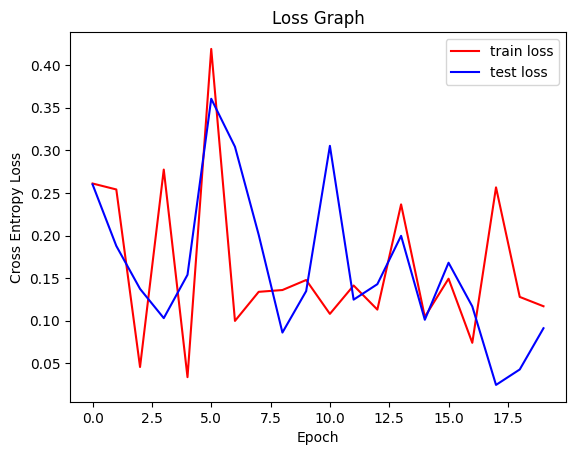

In [63]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

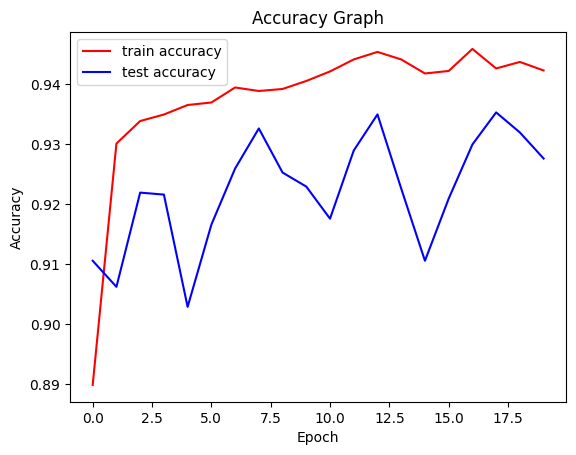

In [64]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [65]:
torch.save(densenet121,'lung_cancer_densenet_detector.pt')